<a href="https://colab.research.google.com/github/rabiyulfahimhasim786/imagerecaptcha/blob/main/imagerecaptcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install network

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for network: filename=network-0.1-py3-none-any.whl size=3138 sha256=59c25cb60519554ed288ba9130bb94ffb45d45ecd3bda1ff4fec0533f09ff909
  Stored in directory: /root/.cache/pip/wheels/25/97/b1/563d3a70ed8f588bf9cf448f079024a9751b54d15a0ce3d46b
Successfully built network


In [2]:
import torch.nn as nn

# Convolutional neural network (two convolutional layers)

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(896, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

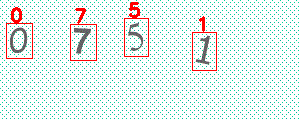

-1

In [3]:
import numpy as np
import torch
import cv2
import imutils
# from network import ConvNet
from google.colab.patches import cv2_imshow
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the network
model = ConvNet().to(device)

# Loading the weights
model.load_state_dict(torch.load('model_final.ckpt'))

# Eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
model.eval()

image = cv2.imread("test.png")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Hack for compatibility with different OpenCV versions
contours = contours[1] if imutils.is_cv3() else contours[0]

letter_image_regions = []
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    if w <= 9 or h <= 9:
        continue

    # print(x, y, w, h)
    letter_image_regions.append((x, y, w, h))

# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

predicted_number = ""
output_img = cv2.merge([image])
for letter_bounding_box in letter_image_regions:
    x, y, w, h = letter_bounding_box
    letter_image = gray[y:y + h, x:x + w]

    letter_image = letter_image[0:30, 0:18]

    shape_x, shape_y = letter_image.shape

    # new_img = np.resize(letter_image, (28, 28))
    fill_width = np.ones([shape_x, 18 - shape_y]) * 255
    fill_height = np.ones([30 - shape_x, 18]) * 255

    new_img = np.concatenate((letter_image, fill_width), 1)
    new_img = np.concatenate((new_img, fill_height), 0)

    new_img /= 255  # normalize

    with torch.no_grad():
        arg = torch.from_numpy(np.array([[new_img]]))
        output = model(arg.float())

        _, predicted = torch.max(output.data, 1)

        letter = str(int(predicted[0]))
        predicted_number += letter

        cv2.rectangle(output_img, (x - 4, y - 4), (x + w + 5, y + h + 5), (0, 0, 255), 1)
        cv2.putText(output_img, letter, (x, y - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# cv2.imshow('image', output_img)
# cv2.waitKey()
cv2_imshow(output_img)
cv2.waitKey()


In [4]:
print(predicted_number)

0751
